#### Useful imports

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from script import *
%load_ext autoreload
%autoreload 2

#### Load data

In [2]:
DATA_PATH = '../data/405.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


#### Create index and select feature columns

In [3]:
data.crossTime.is_unique

False

In [4]:
duplicates = data[data.duplicated()]
duplicates

,crossTime,speed,weight
1027596,2013-01-11 16:27:18.500,88,8260
1246476,2013-06-18 18:36:40.600,86,11190
1670099,2015-07-27 12:41:01.600,89,3530
1751529,2015-09-15 14:22:54.900,81,5470
2246137,2016-07-22 12:58:58.200,25,3590
2710589,2017-06-23 18:05:58.100,90,3580
3355905,2018-07-17 08:53:27.400,90,16470


In [5]:
data[data.crossTime == '2015-07-27 12:41:01.600']

,crossTime,speed,weight
1670098,2015-07-27 12:41:01.600,89,3530
1670099,2015-07-27 12:41:01.600,89,3530


**Note**: Remove duplicates after loading the data

In [6]:
feature_cols = [col for col in data.columns if col != 'crossTime']
features = data[feature_cols]
features.index = data.crossTime

#### Downsample

In [7]:
sampling_intervals = ['1h', '30min', '10min', '2min']

resampled = [features.resample(i) for i in sampling_intervals]
features = [resample.sum() for resample in resampled]
print(len(resampled) == len(features))
for i in range(len(resampled)):
    features[i]['n_vehicles'] = resampled[i].size()
    
features[0][:2]

True


,speed,weight,n_vehicles
crossTime,,,
2011-04-01 00:00:00,306,38090,3
2011-04-01 01:00:00,540,107870,6


#### Feature engineering

In [ ]:
# HGV movement restrictions
legal_driving_start = 5
legal_driving_end = 22
legal_driving_duration = legal_driving_end - legal_driving_start
sunday = 6

dayofweek = [pd.Series(fs.index.dayofweek, index=fs.index) for fs in features]
hours = [pd.Series(fs.index.hour, index=fs.index) for fs in features]
shifted_hours = hours - legal_driving_start

for i in range(len(features)):
    features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
    features.head(10)

In [9]:
def pipeline(sampling_interval):
    
    feature_cols = [col for col in data.columns if col != 'crossTime']
    features = data[feature_cols]
    features.index = data.crossTime

    # Downsample and add vehicle counts
    resampled = features.resample(sampling_interval)
    features = resampled.sum()
    features['n_vehicles'] = resampled.size()
    
    ## FEATURE ENGINEERING
    
    # HGV movement restrictions #
    legal_driving_start = 5
    legal_driving_end = 22
    legal_driving_duration = legal_driving_end - legal_driving_start
    sunday = 6
    
    dayofweek = pd.Series(features.index.dayofweek, index=features.index)
    hours = pd.Series(features.index.hour, index=features.index)
    shifted_hours = hours - legal_driving_start
    
    features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
    
    # Time periodicity features #
    # Transform to seconds
    timestamp_s = features.index.map(pd.Timestamp.timestamp)

    # Corresponding length in seconds for day, week, year
    minute_s = 60
    hour_s = minute_s * 60
    day_s = 24 * hour_s # 24h x 60m x 60s
    week_s = 7 * day_s
    year_s = 365.2425 * day_s
    
    # Add sin/cos periodicity columns to features dataframe
    def add_time_period_cols(time_length, time_string):
        features[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
        features[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))

    add_time_period_cols(day_s, 'day')
    add_time_period_cols(week_s, 'week')
    add_time_period_cols(year_s, 'year')
    
    return split_norm_data(features, return_mean_std=True)

In [ ]:
train, val, test, train_mean, train_std = pipeline('1h')

In [10]:
val_performance = {}
performance = {}

In [11]:
# List of tuples (interval, n_intervals that account for 1 hour)
sampling_intervals = [('1h', 1), ('30min', 2), ('10min', 6), ('2min', 30)]

In [12]:
rnn = lstm_model()

In [13]:
for i in range(len(sampling_intervals)):
    interval, day_width = sampling_intervals[i]
    print(f'Interval: {interval}')
    DAY_W = 24 * day_width
    train, val, test, _, _ = pipeline(interval)
    # window = make_window(train, val, test, input_w=7*DAY_W, label_w=DAY_W)
    w_window = wide_window(train, val, test)
    
    history = compile_and_fit(rnn, w_window)
    IPython.display.clear_output()
    val_performance[interval] = rnn.evaluate(w_window.val)
    performance[interval] = rnn.evaluate(w_window.test, verbose=0)

16425/16425 [==============================] - 123s 7ms/step - loss: 0.3610 - mean_absolute_error: 0.3701 - ETA: 0s - loss: 0.3610 - mean_absolute_erro


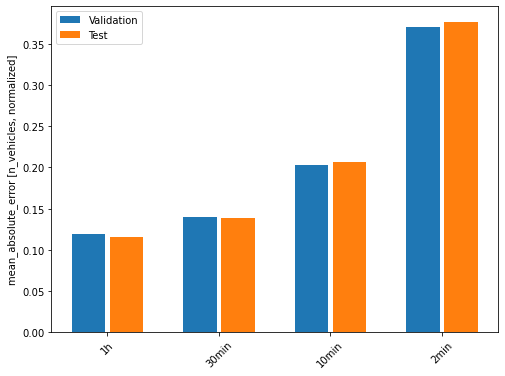

In [14]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = rnn.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [n_vehicles, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [15]:
train, val, test, _, _ = pipeline('1h')

In [21]:
window = make_window(train, val, test, input_w=24, label_w=24)

In [24]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [25]:
compile_and_fit(lstm, window)

Epoch 1/20
1916/1916 [==============================] - 56s 25ms/step - loss: 0.0577 - mean_absolute_error: 0.1432 - val_loss: 0.0481 - val_mean_absolute_error: 0.1307s: 0.0637 - mean_absolu - ETA: 7s - loss: 0.0629 - mean_absolute_error: 0.150 - ETA: 7s - loss: 0.0628 - mea - ETA: 5s - loss: 0
Epoch 2/20
1916/1916 [==============================] - 53s 28ms/step - loss: 0.0287 - mean_absolute_error: 0.1003 - val_loss: 0.0422 - val_mean_absolute_error: 0.1215ute_error: 0.1 - ETA: 7s - loss: 0.0291 - mean - ETA: 5s - loss: 0.0290 -
Epoch 3/20
1916/1916 [==============================] - 41s 21ms/step - loss: 0.0265 - mean_absolute_error: 0.0952 - val_loss: 0.0415 - val_mean_absolute_error: 0.1199 - loss: 0.0266 - 
Epoch 4/20
1916/1916 [==============================] - 46s 24ms/step - loss: 0.0254 - mean_absolute_error: 0.0928 - val_loss: 0.0411 - val_mean_absolute_error: 0.1194solu - ETA: 9s - loss: 0.0256 - ETA: 7s - loss: 0.0256 - mean_absolut - ETA: 7 - ETA: 0s - loss: 0.0254 - mean